<a href="https://colab.research.google.com/github/naldo14/tesis-/blob/main/entrenamiento_bayesiano_eje_y.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
## importo las librerias
import h5py
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix
from tensorflow import keras
from tensorflow.keras.callbacks import LearningRateScheduler
tfd = tfp.distributions
tfpl = tfp.layers
from sklearn.model_selection import train_test_split

In [2]:
## hago el mounting
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Proceso de carga de los datos

### Data de la universidad coreana

In [3]:
path_features="/content/drive/MyDrive/tesis USB /Vibration, acoustic, temperature, and motor current dataset of rotating machine under varying operating conditions for fault diagnosis (korea)/features_y"
with h5py.File(path_features, 'r') as hf:
    x_features = hf['features_y'][:]

In [4]:
path_features="/content/drive/MyDrive/tesis USB /Vibration, acoustic, temperature, and motor current dataset of rotating machine under varying operating conditions for fault diagnosis (korea)/y_targets"
with h5py.File(path_features, 'r') as hf:
    y_targets = hf['y_targets'][:]

### Data from case west reserve university DRIVE END

In [5]:
path_features="/content/drive/MyDrive/tesis USB /case west reserve university/data_1/features"
with h5py.File(path_features, 'r') as hf:
    x_features_1 = hf['features'][:]


In [6]:
path_features="/content/drive/MyDrive/tesis USB /case west reserve university/data_1/targets"
with h5py.File(path_features, 'r') as hf:
    y_targets_1 = hf['targets'][:]

### Data from case west reserve university FAN END

In [7]:
path_features="/content/drive/MyDrive/tesis USB /case west reserve university/data_2/features"
with h5py.File(path_features, 'r') as hf:
    x_features_2= hf['features'][:]


In [8]:
path_features="/content/drive/MyDrive/tesis USB /case west reserve university/data_2/targets"
with h5py.File(path_features, 'r') as hf:
    y_targets_2 = hf['targets'][:]

## Red entrenada con todos los datos de case west drive end y KIST y probada con el data set de case west fan-end

In [37]:
###3 concateno todo
y_targets = y_targets.reshape(len(y_targets), 1)
x_features_3=np.concatenate((x_features ,x_features_2 ))
y_targets_3=np.concatenate((y_targets ,y_targets_2 ))



In [55]:
x_shape = x_features_3.shape[0]
train_ratio = 0.5 # 80% for training
val_ratio = 0.5 # 20% for validation (no test set)

# Split the dataset into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_features_3, y_targets_3, test_size=val_ratio, random_state=42)

# Now, x_train, y_train, x_val, and y_val contain the data and labels for training and validation.

# Shuffle the rows (optional, you can remove this if not needed)
train_indices = np.random.permutation(len(x_train))
val_indices = np.random.permutation(len(x_val))

x_train, y_train = x_train[train_indices], y_train[train_indices]
x_val, y_val = x_val[val_indices], y_val[val_indices] #este set no lo estoy usando , concatenar con el x_features_1 a ver

In [56]:
x_test, y_test= x_features_1,y_targets_1


In [ ]:
x_features_2.shape


(64, 14)

### Creacion de la BNN

In [12]:
## def prior weight distribution N(1,0) and not trainable
# Define the prior weight distribution N(0, 1)
def prior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    prior_model = keras.Sequential(
        [
            tfp.layers.DistributionLambda(
                lambda t: tfp.distributions.MultivariateNormalDiag(
                    loc=tf.zeros(n), scale_diag=tf.ones(n)
                )
            )
        ]
    )
    return prior_model

In [13]:
# Define the posterior weight distribution Multivariate Gaussian distribution
def posterior(kernel_size, bias_size, dtype=None):
    n = kernel_size + bias_size
    posterior_model = keras.Sequential(
        [
            tfp.layers.VariableLayer(
                tfp.layers.MultivariateNormalTriL.params_size(n), dtype=dtype
            ),
            tfp.layers.MultivariateNormalTriL(n),
        ]
    )
    return posterior_model

In [ ]:
!pip install numba

from numba import cuda
device = cuda.get_current_device()
device.reset()

In [57]:
# Define the BNN model
model = tf.keras.Sequential([
    tfpl.DenseVariational(
        input_shape=(14,),
        units=30,
        make_prior_fn=prior,
        make_posterior_fn=posterior,
        activation='relu',
        kl_weight=1/x_train.shape[0],  # KL Weight
        # kl_use_exact=True
    ),

       tfpl.DenseVariational(
        units=25,
        make_prior_fn=prior,
        make_posterior_fn=posterior,
        activation='relu',
        use_bias=True,
        kl_weight=1/x_train.shape[0]  # KL Weight
    ),

    tfpl.DenseVariational(
        units=20,
        make_prior_fn=prior,
        make_posterior_fn=posterior,
        activation='relu',
        use_bias=True,
        kl_weight=1/x_train.shape[0]  # KL Weight
    ),

    tfpl.DenseVariational(
        units=15,
        make_prior_fn=prior,
        make_posterior_fn=posterior,
        activation='relu',
        use_bias=True,
        kl_weight=1/x_train.shape[0]  # KL Weight
    ),


      tfpl.DenseVariational(
        units=12,
        make_prior_fn=prior,
        make_posterior_fn=posterior,
        activation='relu',
        use_bias=True,
        kl_weight=1/x_train.shape[0]  # KL Weight
    ),
    tfpl.DenseVariational(
        units=8,
        make_prior_fn=prior,
        make_posterior_fn=posterior,
        activation='relu',
        use_bias=True,
        kl_weight=1/x_train.shape[0]  # KL Weight
    ),
    tfpl.DenseVariational(
        units=5,
        make_prior_fn=prior,
        make_posterior_fn=posterior,
        activation='relu',
        use_bias=True,
        kl_weight=1/x_train.shape[0]  # KL Weight
    ),
    tfpl.DenseVariational(
        units=1,
        make_prior_fn=prior,
        make_posterior_fn=posterior,
        activation='sigmoid',
        use_bias=True,
        kl_weight=1/x_train.shape[0]  # KL Weight
    ),
])

In [ ]:

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_variational (DenseVa  (None, 30)                101925    
 riational)                                                      
                                                                 
 dense_variational_1 (Dense  (None, 25)                301475    
 Variational)                                                    
                                                                 
 dense_variational_2 (Dense  (None, 20)                135980    
 Variational)                                                    
                                                                 
 dense_variational_3 (Dense  (None, 15)                50085     
 Variational)                                                    
                                                                 
 dense_variational_4 (Dense  (None, 12)                1

In [58]:
# Define a learning rate schedule function
def lr_schedule(epoch):
    if epoch < 100:
        return 0.001  # Initial learning rate for the first 100 epochs
    elif epoch < 200:
        return 0.0001  # Lower learning rate for the next 100 epochs
    else:
        return 0.00001  # Further lower learning rate for subsequent epochs

# Create a learning rate scheduler callback
lr_scheduler = LearningRateScheduler(lr_schedule)

# Compile the model with an optimizer (e.g., Adam) and loss function
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.FalseNegatives(), tf.keras.metrics.FalsePositives()])

# Train the model with the learning rate scheduler callback
history = model.fit(x_train, y_train, epochs=2000, verbose=2)

# Evaluate the model on the test data
test_loss, test_accuracy, false_negatives, false_positives = model.evaluate(x_test, y_test)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy*100:.2f}%")
print(f"False Negatives: {false_negatives:.0f}")
print(f"False Positives: {false_positives:.0f}")

# Make predictions on test data
y_pred = model.predict(x_test)
y_pred_binary = (y_pred >= 0.5).astype(int)

# Calculate confusion matrix
confusion = confusion_matrix(y_test, y_pred_binary)
print("Confusion Matrix:")
print(confusion)


Epoch 1/2000
3/3 - 7s - loss: 30.0862 - accuracy: 0.2603 - false_negatives_6: 53.0000 - false_positives_6: 1.0000 - 7s/epoch - 2s/step
Epoch 2/2000
3/3 - 0s - loss: 20.1639 - accuracy: 0.6301 - false_negatives_6: 22.0000 - false_positives_6: 5.0000 - 26ms/epoch - 9ms/step
Epoch 3/2000
3/3 - 0s - loss: 23.7906 - accuracy: 0.7123 - false_negatives_6: 13.0000 - false_positives_6: 8.0000 - 25ms/epoch - 8ms/step
Epoch 4/2000
3/3 - 0s - loss: 15.1323 - accuracy: 0.7808 - false_negatives_6: 6.0000 - false_positives_6: 10.0000 - 24ms/epoch - 8ms/step
Epoch 5/2000
3/3 - 0s - loss: 19.7935 - accuracy: 0.8493 - false_negatives_6: 0.0000e+00 - false_positives_6: 11.0000 - 24ms/epoch - 8ms/step
Epoch 6/2000
3/3 - 0s - loss: 26.8362 - accuracy: 0.3836 - false_negatives_6: 38.0000 - false_positives_6: 7.0000 - 24ms/epoch - 8ms/step
Epoch 7/2000
3/3 - 0s - loss: 24.1200 - accuracy: 0.7945 - false_negatives_6: 6.0000 - false_positives_6: 9.0000 - 24ms/epoch - 8ms/step
Epoch 8/2000
3/3 - 0s - loss: 55.0

3/3 [==============================] - 0s 4ms/step


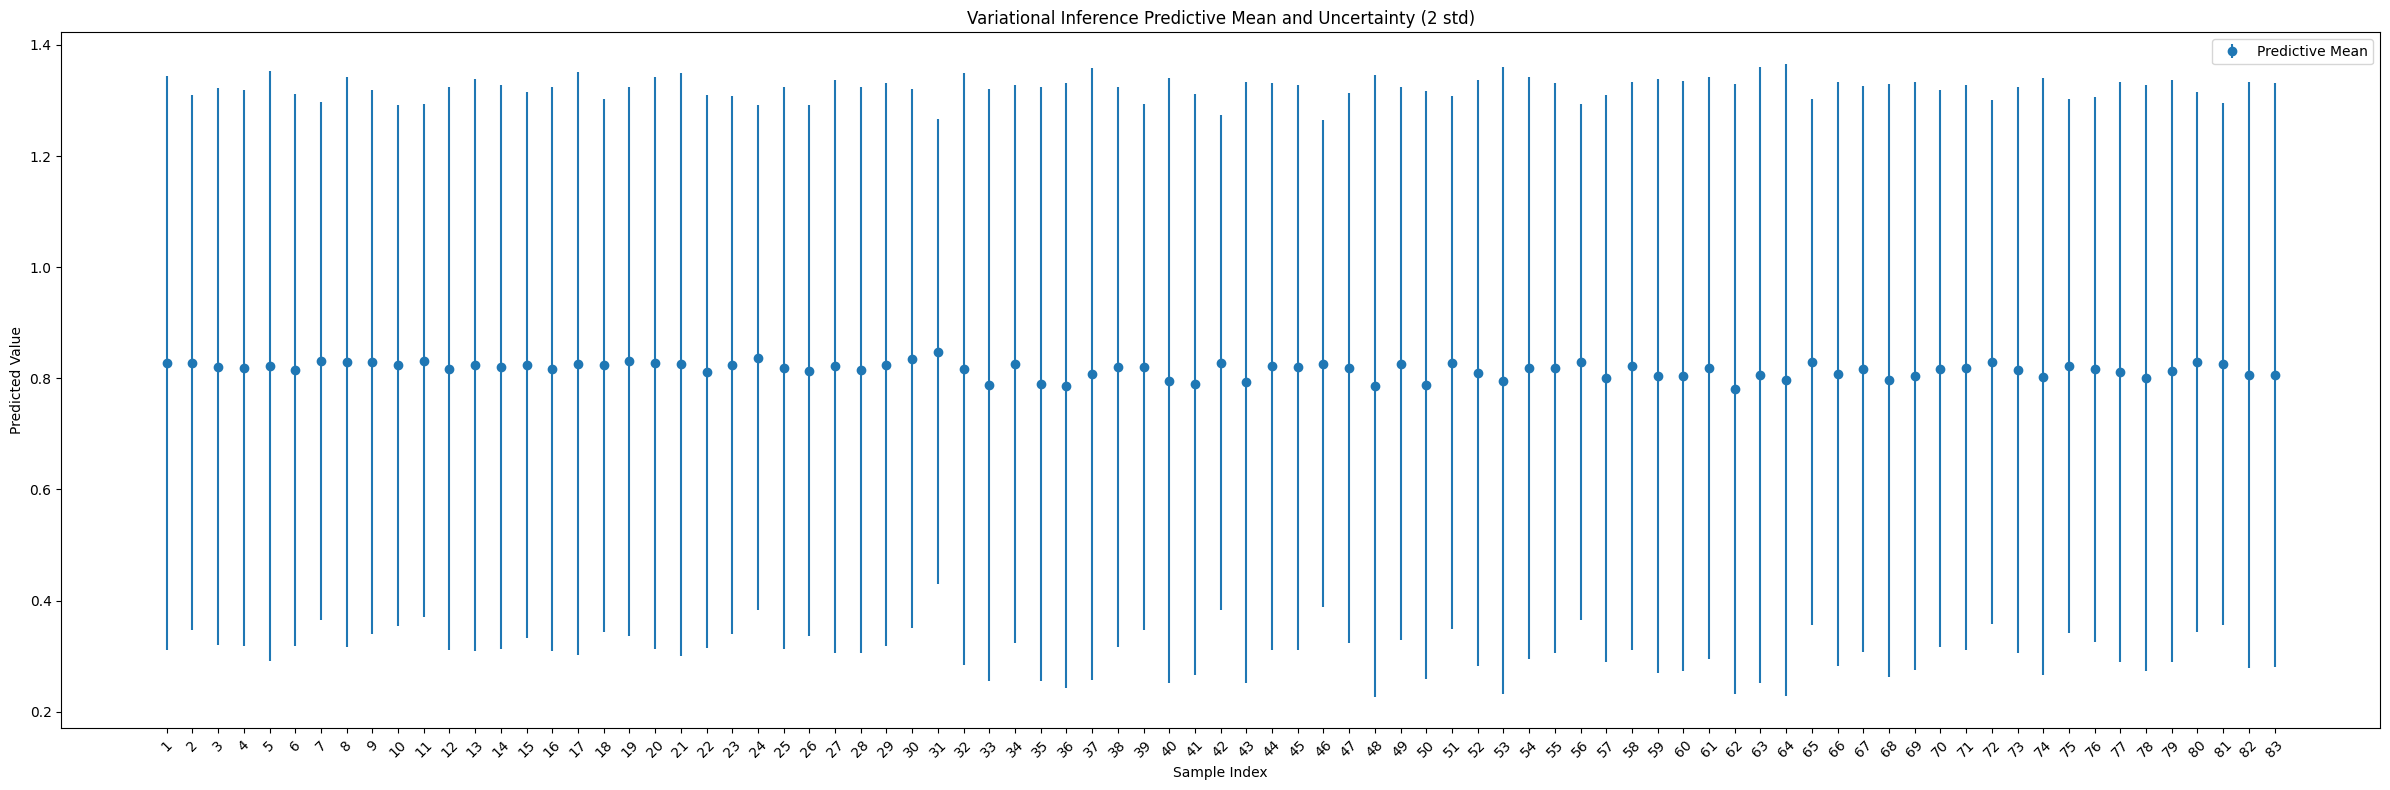

In [60]:
import numpy as np
import matplotlib.pyplot as plt

# Randomly select 80% of the data
n_samples = int(0.8 * len(x_test))
random_indices = np.random.choice(len(x_test), n_samples, replace=False)
x_subset = x_test[random_indices]

# Number of samples for uncertainty estimation
n_samples = 100
predictions = []

# Generate multiple samples from the posterior distribution
for _ in range(n_samples):
    predictions.append(model.predict(x_subset))

# Convert predictions to a NumPy array
predictions = np.array(predictions)

# Calculate the predictive mean and standard deviation
mean_prediction = np.mean(predictions, axis=0).flatten()
std_prediction = np.std(predictions, axis=0).flatten()

# Create x-axis values
x_values = np.arange(1, len(mean_prediction) + 1)

# Plot uncertainty using error bars
plt.figure(figsize=(24, 8))
plt.errorbar(x_values, mean_prediction, yerr=2 * std_prediction, fmt='o', label='Predictive Mean')
plt.xlabel('Sample Index')
plt.ylabel('Predicted Value')
plt.xticks(x_values, rotation=45)
plt.title('Variational Inference Predictive Mean and Uncertainty (2 std)')
plt.legend()
plt.tight_layout()
plt.show()


In [72]:
del model ,history , lr_scheduler , lr_schedule , test_loss , test_accuracy , false_negatives , false_positives , y_pred , y_pred_binary , confusion , n_samples , random_indices , x_subset ,x_train, x_val, y_train, y_val,x_test, y_test

NameError: ignored

## data entrenada con los solo dos data set peri aumentando el tamaño de los train test

In [73]:
###3 concateno todo
y_targets = y_targets.reshape(len(y_targets), 1)
x_features_4=np.concatenate((x_features ,x_features_2))
y_targets_4=np.concatenate((y_targets ,y_targets_2))





In [66]:
del x_features_4,y_targets_4

NameError: ignored

In [74]:
x_train,y_train=x_features_4,y_targets_4
x_test,y_test=x_features_1,y_targets_1

In [32]:
# # Define the ratios for the train, validation, and test sets
# train_ratio = 0.8
# val_ratio = 0.1
# test_ratio = 0.1

# # Split the dataset into a temporary training set and a test set
# x_temp, x_test, y_temp, y_test = train_test_split(x_features_4, y_targets_4, test_size=test_ratio, random_state=42)

# # Split the temporary dataset into a training set and a validation set
# x_train, x_val, y_train, y_val = train_test_split(x_temp, y_temp, test_size=val_ratio / (1 - test_ratio), random_state=42)

# # Now, x_train, y_train, x_val, y_val, x_test, and y_test contain the data and labels for each set

In [75]:
# Define the BNN model
model = tf.keras.Sequential([
    tfpl.DenseVariational(
        input_shape=(14,),
        units=30,
        make_prior_fn=prior,
        make_posterior_fn=posterior,
        activation='relu',
        kl_weight=1/x_train.shape[0],  # KL Weight
        # kl_use_exact=True
    ),

       tfpl.DenseVariational(
        units=25,
        make_prior_fn=prior,
        make_posterior_fn=posterior,
        activation='relu',
        use_bias=True,
        kl_weight=1/x_train.shape[0]  # KL Weight
    ),

    tfpl.DenseVariational(
        units=20,
        make_prior_fn=prior,
        make_posterior_fn=posterior,
        activation='relu',
        use_bias=True,
        kl_weight=1/x_train.shape[0]  # KL Weight
    ),

    tfpl.DenseVariational(
        units=15,
        make_prior_fn=prior,
        make_posterior_fn=posterior,
        activation='relu',
        use_bias=True,
        kl_weight=1/x_train.shape[0]  # KL Weight
    ),


      tfpl.DenseVariational(
        units=12,
        make_prior_fn=prior,
        make_posterior_fn=posterior,
        activation='relu',
        use_bias=True,
        kl_weight=1/x_train.shape[0]  # KL Weight
    ),
    tfpl.DenseVariational(
        units=8,
        make_prior_fn=prior,
        make_posterior_fn=posterior,
        activation='relu',
        use_bias=True,
        kl_weight=1/x_train.shape[0]  # KL Weight
    ),
    tfpl.DenseVariational(
        units=5,
        make_prior_fn=prior,
        make_posterior_fn=posterior,
        activation='relu',
        use_bias=True,
        kl_weight=1/x_train.shape[0]  # KL Weight
    ),
    tfpl.DenseVariational(
        units=1,
        make_prior_fn=prior,
        make_posterior_fn=posterior,
        activation='sigmoid',
        use_bias=True,
        kl_weight=1/x_train.shape[0]  # KL Weight
    ),
])

In [76]:
# Define a learning rate schedule function
def lr_schedule(epoch):
    if epoch < 100:
        return 0.001  # Initial learning rate for the first 100 epochs
    elif epoch < 200:
        return 0.0001  # Lower learning rate for the next 100 epochs
    else:
        return 0.00001  # Further lower learning rate for subsequent epochs

# Create a learning rate scheduler callback
lr_scheduler = LearningRateScheduler(lr_schedule)

# Compile the model with an optimizer (e.g., Adam) and loss function
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy', tf.keras.metrics.FalseNegatives(), tf.keras.metrics.FalsePositives()])

# Train the model with the learning rate scheduler callback
history = model.fit(x_train, y_train, epochs=1000, verbose=2)

# Evaluate the model on the test data
test_loss, test_accuracy, false_negatives, false_positives = model.evaluate(x_test, y_test)

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy*100:.2f}%")
print(f"False Negatives: {false_negatives:.0f}")
print(f"False Positives: {false_positives:.0f}")

# Make predictions on test data
y_pred = model.predict(x_test)
y_pred_binary = (y_pred >= 0.5).astype(int)

# Calculate confusion matrix
confusion = confusion_matrix(y_test, y_pred_binary)
print("Confusion Matrix:")
print(confusion)


Epoch 1/1000
5/5 - 8s - loss: 95.4396 - accuracy: 0.1507 - false_negatives_8: 124.0000 - false_positives_8: 0.0000e+00 - 8s/epoch - 2s/step
Epoch 2/1000
5/5 - 0s - loss: 19.4568 - accuracy: 0.6027 - false_negatives_8: 46.0000 - false_positives_8: 12.0000 - 39ms/epoch - 8ms/step
Epoch 3/1000
5/5 - 0s - loss: 49.0012 - accuracy: 0.2877 - false_negatives_8: 98.0000 - false_positives_8: 6.0000 - 37ms/epoch - 7ms/step
Epoch 4/1000
5/5 - 0s - loss: 24.4004 - accuracy: 0.4247 - false_negatives_8: 74.0000 - false_positives_8: 10.0000 - 39ms/epoch - 8ms/step
Epoch 5/1000
5/5 - 0s - loss: 20.1738 - accuracy: 0.5342 - false_negatives_8: 58.0000 - false_positives_8: 10.0000 - 37ms/epoch - 7ms/step
Epoch 6/1000
5/5 - 0s - loss: 39.7878 - accuracy: 0.6986 - false_negatives_8: 30.0000 - false_positives_8: 14.0000 - 39ms/epoch - 8ms/step
Epoch 7/1000
5/5 - 0s - loss: 10.7574 - accuracy: 0.4863 - false_negatives_8: 64.0000 - false_positives_8: 11.0000 - 38ms/epoch - 8ms/step
Epoch 8/1000
5/5 - 0s - los

3/3 [==============================] - 0s 4ms/step


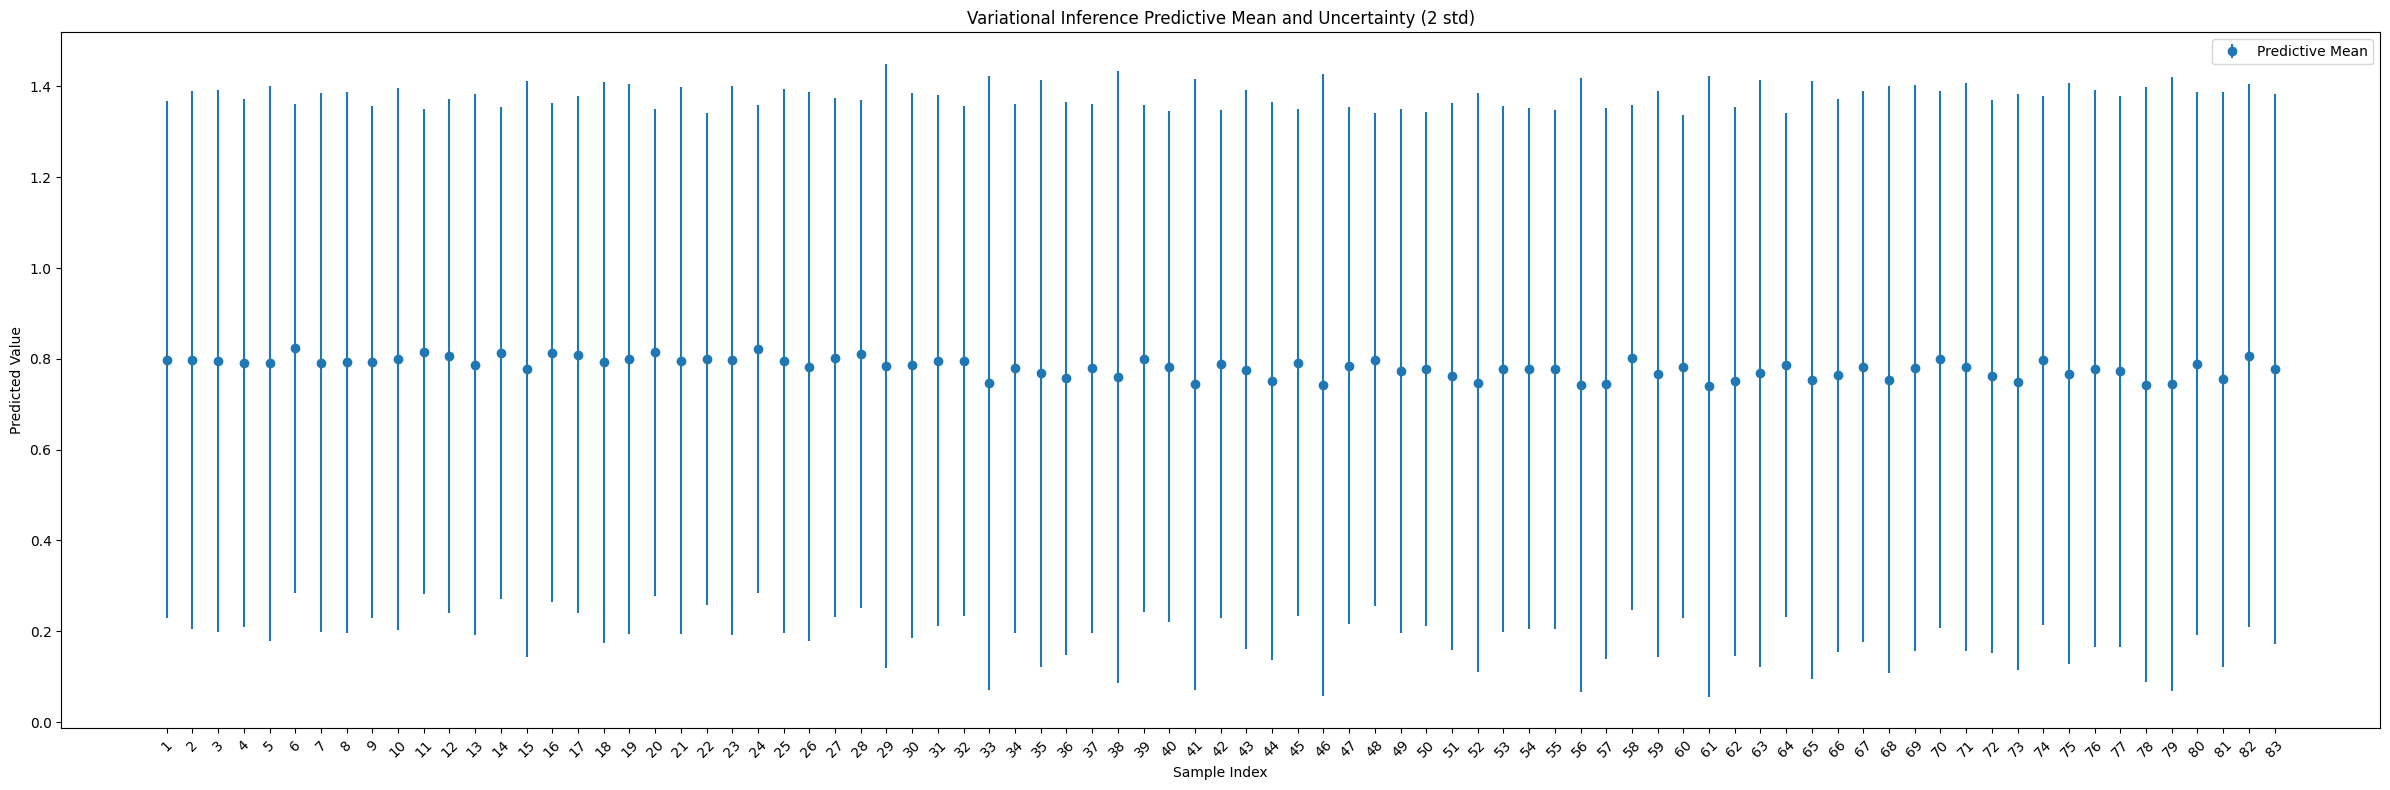

In [77]:
import numpy as np
import matplotlib.pyplot as plt

# Randomly select 80% of the data
n_samples = int(0.8 * len(x_test))
random_indices = np.random.choice(len(x_test), n_samples, replace=False)
x_subset = x_test[random_indices]

# Number of samples for uncertainty estimation
n_samples = 100
predictions = []

# Generate multiple samples from the posterior distribution
for _ in range(n_samples):
    predictions.append(model.predict(x_subset))

# Convert predictions to a NumPy array
predictions = np.array(predictions)

# Calculate the predictive mean and standard deviation
mean_prediction = np.mean(predictions, axis=0).flatten()
std_prediction = np.std(predictions, axis=0).flatten()

# Create x-axis values
x_values = np.arange(1, len(mean_prediction) + 1)

# Plot uncertainty using error bars
plt.figure(figsize=(24, 8))
plt.errorbar(x_values, mean_prediction, yerr=2 * std_prediction, fmt='o', label='Predictive Mean')
plt.xlabel('Sample Index')
plt.ylabel('Predicted Value')
plt.xticks(x_values, rotation=45)
plt.title('Variational Inference Predictive Mean and Uncertainty (2 std)')
plt.legend()
plt.tight_layout()
plt.show()
